In [5]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from matplotlib.ticker import FormatStrFormatter
from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
%matplotlib inline
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Functions to get data
key_m1m3_dict={'1 X': 'm1m3_x_1', 
            '1 Y': 'm1m3_y_1', 
            '1 Z': 'm1m3_z_1', 
            '2 X': 'm1m3_x_2', 
            '2 Y': 'm1m3_z_2', # note these two have been 
            '2 Z': 'm1m3_y_2', # switched pending SUMMIT-7911
            '3 X': 'm1m3_x_3', 
            '3 Y': 'm1m3_y_3', 
            '3 Z': 'm1m3_z_3'
            }
key_m2_dict={'1 X': 'm2_x_1', 
            '1 Y': 'm2_y_1', 
            '1 Z': 'm2_z_1', 
            '2 X': 'm2_x_2', 
            '2 Y': 'm2_z_2', 
            '2 Z': 'm2_y_2', 
            '3 X': 'm2_x_3', 
            '3 Y': 'm2_z_3', 
            '3 Z': 'm2_y_3', 
            '4 X': 'm2_x_4', 
            '4 Y': 'm2_y_4', 
            '4 Z': 'm2_z_4', 
            '5 X': 'm2_x_5', 
            '5 Y': 'm2_z_5', 
            '5 Z': 'm2_y_5',
            '6 X': 'm2_x_6', 
            '6 Y': 'm2_z_6', 
            '6 Z': 'm2_y_6', 
            }
def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict=key_m1m3_dict
    elif vms_type=="m2":
        key_dict=key_m2_dict
    elif vms_type=="rotator":
        raise NotImplementedError
    else:
        raise ValueError('vms_type must be m1m3,m2, or rotator')

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    dkeys = 'XYZ'
   
    data_dict = {}
    if (begin_time is not None) & (end_time is not None): 
        sel = (times > begin_time) & (times < end_time)
    else: 
        sel = np.ones(times.size).astype(bool)
    data_dict['times'] = times[sel]  
    for key in key_dict.keys():
        data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict)/3)) +1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x","y","z"]]].values, axis=1
        )
    
    
    return data_frame

def get_freq_psd(vals, timestep):

    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)

def get_peak_points(freq, psd, height=0.01):
    """
    Get the peak points of the power spectral density (PSD).

    Args:
        freq (numpy.ndarray): The frequency vector.
        psd (numpy.ndarray): The power spectral density.
        height (float): The minimum peak height.

    Returns:
        numpy.ndarray: The peak points.
    """

    # Find the peak indices and heights.
    peak_ind, peak_dict = find_peaks(psd, height=height)
    peaks = freq[peak_ind]

    # If there are no peaks, return None.
    if len(peaks) < 1:
        return None

    # Find the sub-peaks within each group of peaks that are close in frequency.
    points = []
    for i, peak in enumerate(peaks):
        sel = (abs(peaks - peak) < 1)
        sub_peaks = peaks[sel]
        sub_heights = peak_dict['peak_heights'][sel]
        points.append(sub_peaks[np.argmax(sub_heights)])

    # Return the unique peak points.
    return np.unique(np.array(points))

if you can please check M1M3 VMS data local time (UTC-3) 11:20-12:30 and 14:40-15:00 - when we run the FCUs

In [ ]:
14:20-15:30

In [48]:
table="lsst.sal.MTM1M3.accelerometerData"
begin_time=Time('2023-12-07 14:20:00.00')
end_time=Time('2023-12-07 15:30:00.00')
client = EfdClient("usdf_efd")
vms_m1m3_filename="/home/p/pferguso/u/scratch/vms_data/12/M1M3-2023-12-07T00:00.hdf"

In [49]:
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

In [50]:
axis_table = { 0: "1_x",
               1: "1_y",
               2: "2_x",
               3: "2_y",
               4: "3_x",
               5: "3_y", 
               6: "4_x",
               7: "4_y",
}

Text(0.5, 0.99, 'M1M3 FCU #1\n2023-12-07 14:20:00-15:30:00\n Total Vibration')

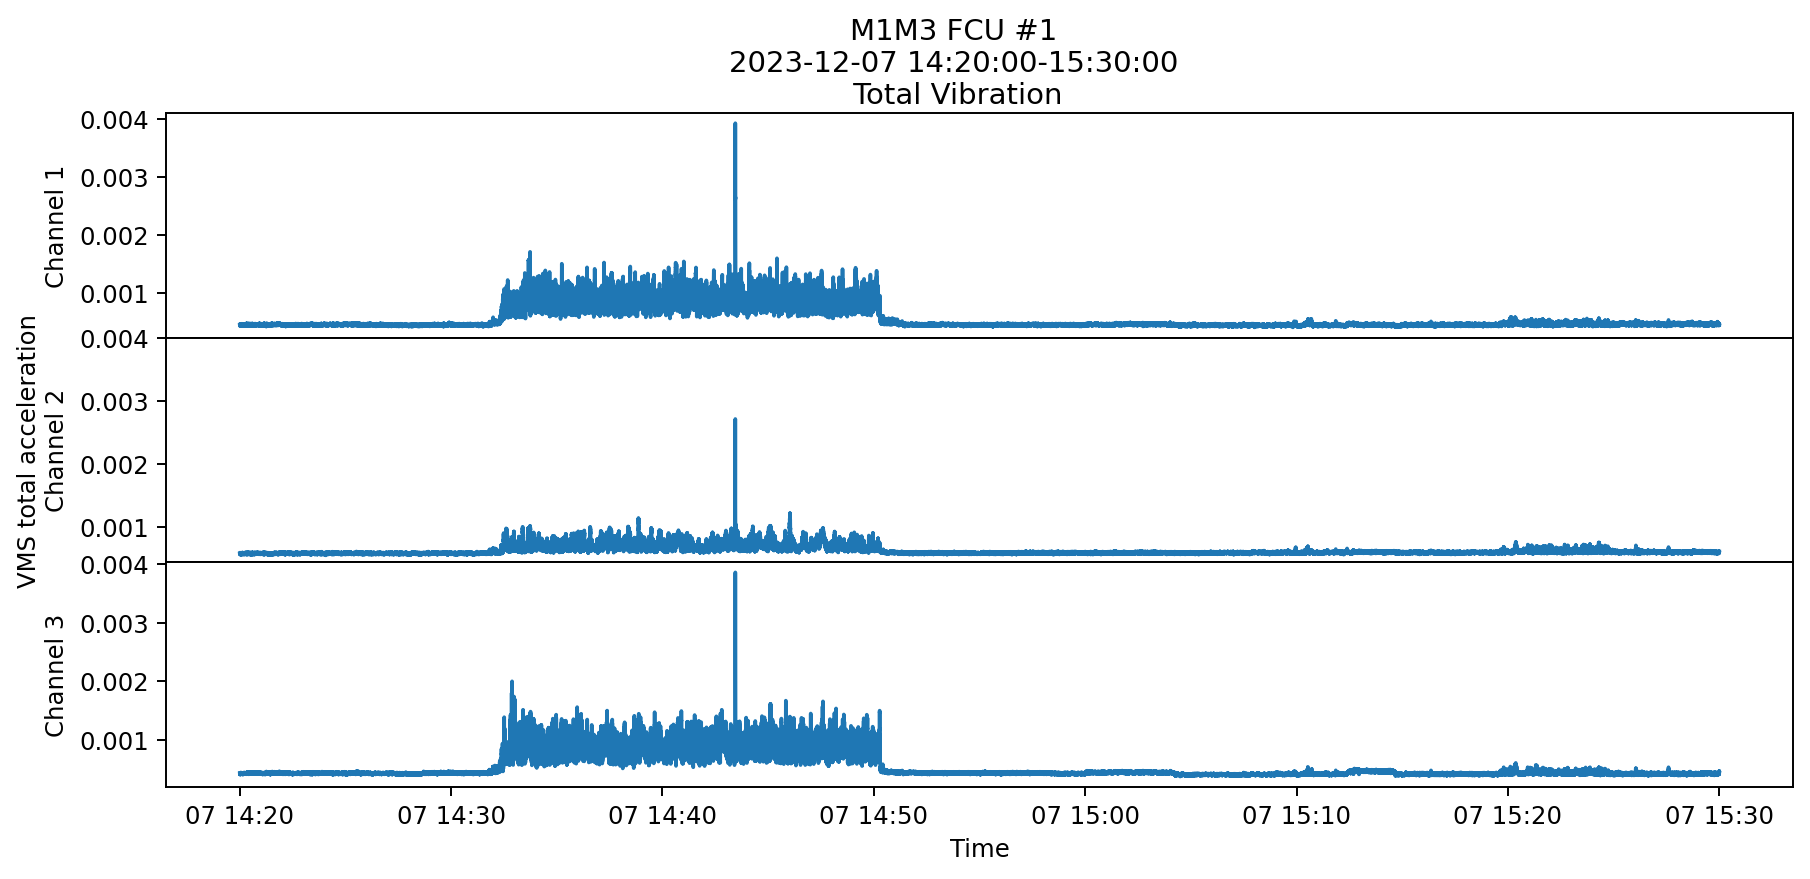

In [52]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(12,5), dpi=175)
accel_smooth=50
vms_times=Time(vms_m1m3_data["times"], format="unix").datetime
for i in range(3):
    ax=axs[i]
    ax.plot(vms_times, vms_m1m3_data[f"total_{i+1}"].rolling(50).mean(), label=i+1)
    
    ax.set_yticks(np.arange(0.001,0.005,0.001))
plt.subplots_adjust(hspace=0)
axs[1].set_ylabel("VMS total acceleration\nChannel 2")
axs[0].set_ylabel("Channel 1")
axs[2].set_ylabel("Channel 3")
ax.set_xlabel("Time")
fig.suptitle(f"M1M3 FCU #1\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n Total Vibration", y=0.99)


In [53]:
begin_time=Time('2023-12-07 14:30:00.00')
end_time=Time('2023-12-07 14:50:00.00')
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

total_1: 0, 6, 35, 37, 42, 51, 54, 60, 78, 84, 96 Hz
total_2: 0, 24, 42, 80, 85 Hz
total_3: 0, 6, 35, 42, 51, 54, 60, 71, 78, 84, 97 Hz


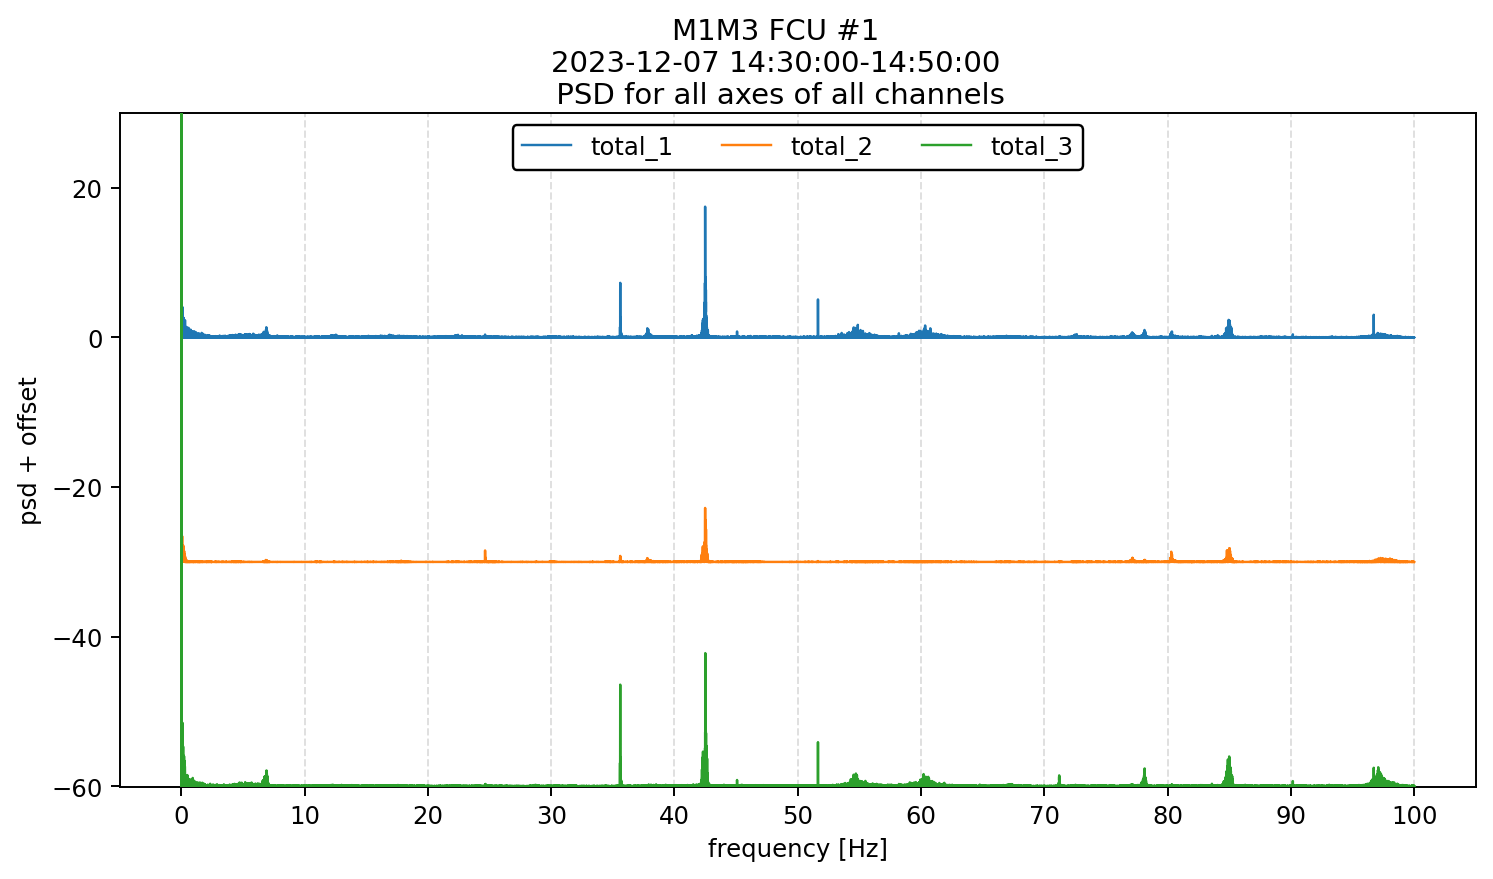

In [54]:
plt.figure(dpi=175,figsize=(10,5))
plt.suptitle(f"M1M3 FCU #1\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n PSD for all axes of all channels", y=0.99)
step=30
for i,key in enumerate([i for i in sorted(vms_m1m3_data.keys()) if ("total" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    points_x=get_peak_points(freq, psd, height=1)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        print(f"{key}: {str([int(i) for i in points_x])[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
plt.ylim(-0.05 - i * step, step)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
_=plt.xticks(np.arange(0,110,10))


# Event 2
17:40-18:00


In [65]:
begin_time=Time('2023-12-07 17:30:00.00')
end_time=Time('2023-12-07 18:50:00.00')
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

Text(0.5, 0.99, 'M1M3 FCU #2\n2023-12-07 17:30:00-18:50:00\n Total Vibration')

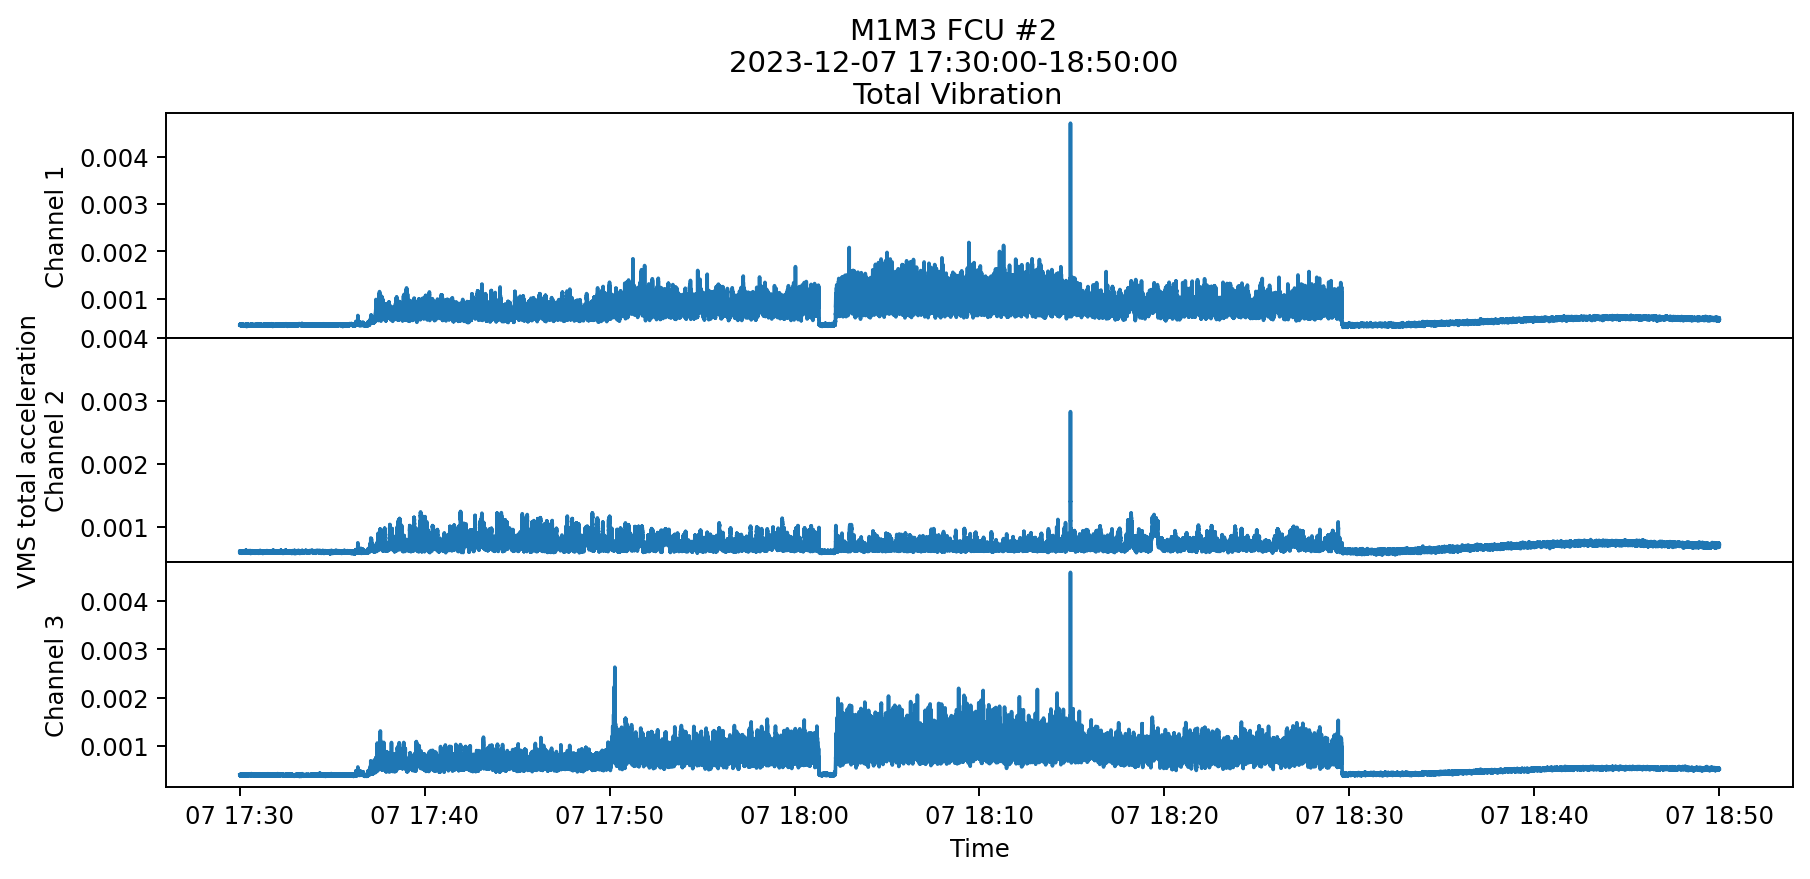

In [66]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(12,5), dpi=175)
accel_smooth=50
vms_times=Time(vms_m1m3_data["times"], format="unix").datetime
for i in range(3):
    ax=axs[i]
    ax.plot(vms_times, vms_m1m3_data[f"total_{i+1}"].rolling(50).mean(), label=i+1)
    
    ax.set_yticks(np.arange(0.001,0.005,0.001))
plt.subplots_adjust(hspace=0)
axs[1].set_ylabel("VMS total acceleration\nChannel 2")
axs[0].set_ylabel("Channel 1")
axs[2].set_ylabel("Channel 3")
ax.set_xlabel("Time")
fig.suptitle(f"M1M3 FCU #2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n Total Vibration", y=0.99)


In [67]:
begin_time=Time('2023-12-07 17:35:00.00')
end_time=Time('2023-12-07 18:30:00.00')
vms_m1m3_data=vms_data_to_pandas(vms_m1m3_filename, vms_type="m1m3",begin_time=begin_time.unix, end_time=end_time.unix)

total_1: 0, 38, 42, 45, 51, 58, 84, 90, 96 Hz
total_2: 0, 38, 42, 45, 76, 84, 97 Hz
total_3: 0, 38, 42, 45, 51, 58, 84, 90, 96 Hz


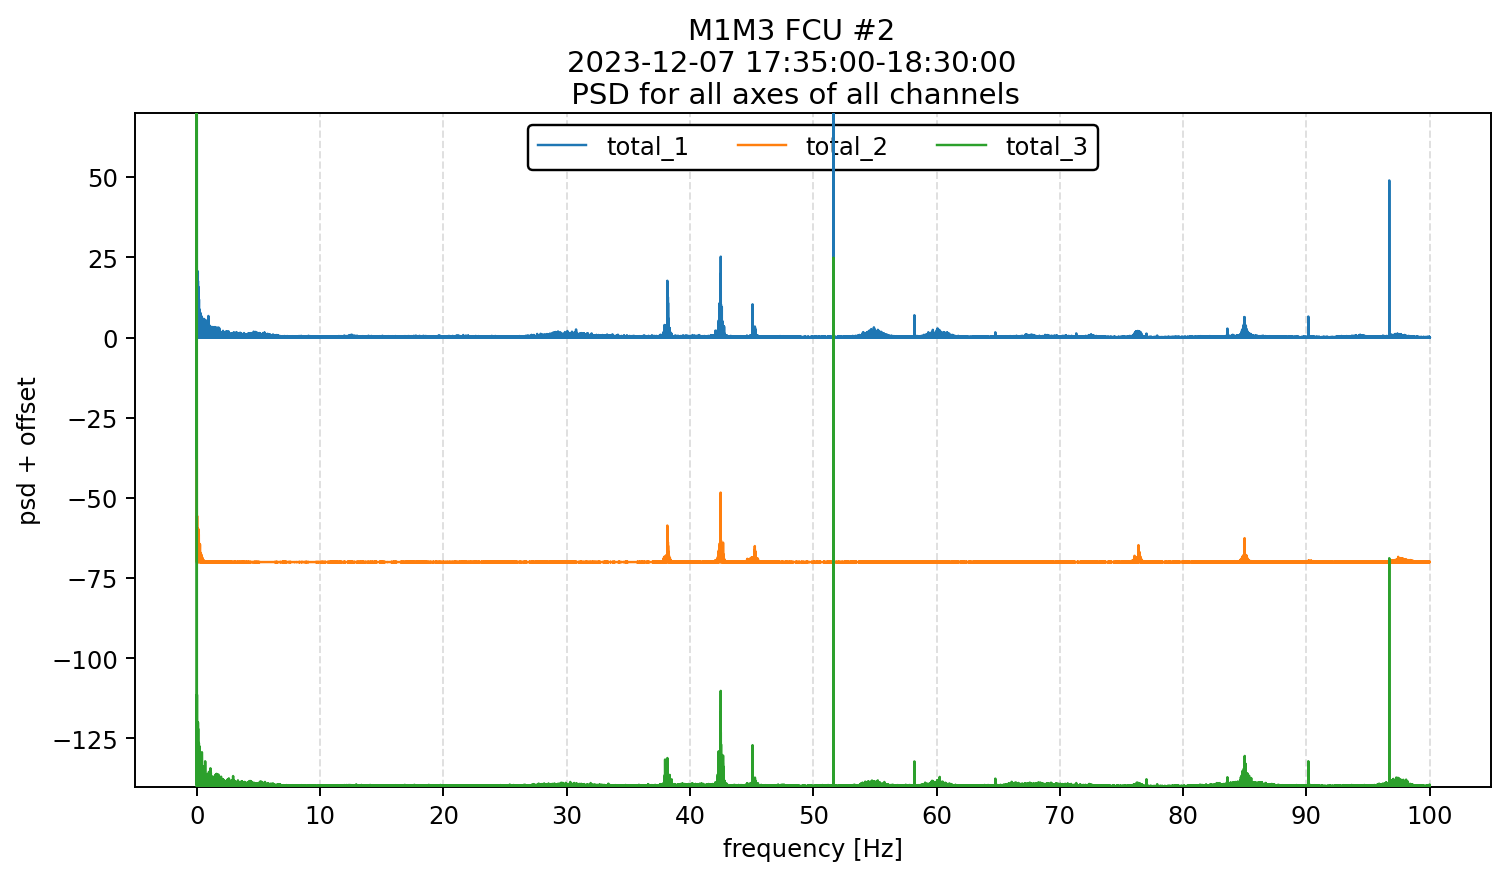

In [79]:
plt.figure(dpi=175,figsize=(10,5))
plt.suptitle(f"M1M3 FCU #2\n{begin_time.iso[:10]} {begin_time.iso[11:19]}-{end_time.iso[11:19]}\n PSD for all axes of all channels", y=0.99)
step=70
for i,key in enumerate([i for i in sorted(vms_m1m3_data.keys()) if ("total" in i)]):
    
    freq,psd=get_freq_psd(vms_m1m3_data[key], np.mean(np.diff(vms_m1m3_data["times"])))
    if i == 1:
        height=1
    else:
        height=6
    points_x=get_peak_points(freq, psd, height=height)
    if points_x is not None:
        points_y=np.ones_like(points_x) * i * step * -1
        print(f"{key}: {str(sorted(np.unique([int(i) for i in points_x])))[1:-1]} Hz")
    else: 
        print(f"{key} no peaks")
    plt.plot(freq,psd - i * step, label=key, zorder=9, lw=1)

plt.legend(ncol=3, edgecolor="k", facecolor="white", loc=9, framealpha=1)
plt.ylim(-0.05 - i * step, step)
plt.xlabel("frequency [Hz]")
plt.ylabel("psd + offset")
plt.grid(visible=True, axis="x", ls="dashed", alpha=0.4)
_=plt.xticks(np.arange(0,110,10))
